<a href="https://colab.research.google.com/github/MattJCR/scrapy_faces/blob/master/scrapy_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación del proyecto

In [1]:
# instalación de Scrapy
!pip install Scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 5.2 MB/s 
     |████████████████████████████████| 3.1 MB 65.5 MB/s 
     |████████████████████████████████| 261 kB 34.1 MB/s 
     |████████████████████████████████| 4.0 MB 14.6 MB/s 
     |████████████████████████████████| 57 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 74 kB 1.5 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.6-py3-none-any.whl size=11959 sha256=59a339dfecd16a81ec9f004c2a449c3e6a56c39f1aa9c8681f60aadf7b0becfe
  Stored in directory: /root/.cache/pip/wheels/dc/b9/4a/948b1176e084b9e3f85e4ffc3d08f817b1fdf0d973bbb94f81
Successfully built PyDispatcher


In [2]:
# creación del proyecto
!scrapy startproject project_faces scrapy

New Scrapy project 'project_faces', using template directory '/usr/local/lib/python3.8/dist-packages/scrapy/templates/project', created in:
    /content/scrapy

You can start your first spider with:
    cd scrapy
    scrapy genspider example example.com


In [3]:
# creación del spider
!cd scrapy/project_faces && scrapy genspider FindFaces https://www.pexels.com/

Created spider 'FindFaces' using template 'basic' in module:
  project_faces.spiders.FindFaces


## Edición de path/to/settings.py



*   USER_AGENT
*   ROBOTSTXT_OBEY
*   DEFAULT_REQUEST_HEADERS



In [4]:
%%writefile scrapy/project_faces/settings.py

BOT_NAME = 'project_faces'

SPIDER_MODULES = ['project_faces.spiders']
NEWSPIDER_MODULE = 'project_faces.spiders'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'

ROBOTSTXT_OBEY = False

DEFAULT_REQUEST_HEADERS = {
   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
   'Accept-Language': 'es',
}

REQUEST_FINGERPRINTER_IMPLEMENTATION = '2.7'
TWISTED_REACTOR = 'twisted.internet.asyncioreactor.AsyncioSelectorReactor'

Overwriting scrapy/project_faces/settings.py


# Implementación del spider

In [5]:
%%writefile scrapy/project_faces/spiders/FindFaces.py
import scrapy

class FindfacesSpider(scrapy.Spider):
    name = 'FindFaces'
    allowed_domains = ['https://www.larajade.com/']
    start_urls = ['https://www.larajade.com/']
    pages = 1
    def parse(self, response):
      images = response.xpath('//body/div/div[id("site")]/div[id("content")]/main/div[contains(@class, "main-content")]/div/div/div/div/div')
      print('numero de entradas:', len(images))
      for img in images:
        img = img.xpath('img/@data-src').get()
        yield {
          'img': img
        }

Overwriting scrapy/project_faces/spiders/FindFaces.py


## Ejecución del spider

In [26]:
!rm -r scrapy/project_faces/faces.json
!cd scrapy/project_faces && scrapy crawl FindFaces -o faces.json

2022-12-08 11:38:42 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: project_faces)
2022-12-08 11:38:42 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.14, cssselect 1.2.0, parsel 1.7.0, w3lib 2.1.0, Twisted 22.10.0, Python 3.8.15 (default, Oct 12 2022, 19:14:39) - [GCC 7.5.0], pyOpenSSL 22.1.0 (OpenSSL 3.0.7 1 Nov 2022), cryptography 38.0.4, Platform Linux-5.10.133+-x86_64-with-glibc2.27
2022-12-08 11:38:42 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'project_faces',
 'NEWSPIDER_MODULE': 'project_faces.spiders',
 'REQUEST_FINGERPRINTER_IMPLEMENTATION': '2.7',
 'SPIDER_MODULES': ['project_faces.spiders'],
 'TWISTED_REACTOR': 'twisted.internet.asyncioreactor.AsyncioSelectorReactor',
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}
2022-12-08 11:38:42 [asyncio] DEBUG: Using selector: EpollSelector
2022-12-08 11:38:42 [scrapy.utils.log] DEBUG: Using reactor: twis

## Procesando las caras de las imágenes

In [8]:
from io import BytesIO
import cv2
from PIL import Image
import json
import numpy as np
import requests

In [35]:
json_file = 'scrapy/project_faces/faces.json'
with open(json_file, 'r') as f:
  data = json.load(f)

images = []
for item in data:
  url = item['img']
  img = Image.open(BytesIO(requests.get(url).content))
  # img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  images.append(img)

In [37]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces_coords = []
face_count = 0
faces_list = []
for img in images:
  img = np.array(img)
  gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor = 1.2,
        minNeighbors = 8,
        minSize = (30, 30)
  )
  w = img.shape[1]
  h = img.shape[0]
  for face in faces:
    x = face[1]
    y = face[0]
    w = face[3]
    h = face[2]
    faces_list.append(img[x:x+w,y:y+h])
  faces_coords.append(faces)
  face_count += len(faces)
face_count

183 90 - 581 90
74 197 - 389 197
91 191 - 303 191
184 767 - 127 767
109 608 - 966 608
193 181 - 636 181
157 299 - 263 299
2074 55 - 1467 55
288 232 - 454 232
157 216 - 462 216
303 270 - 560 270
216 54 - 502 54
31 285 - 357 285
138 315 - 299 315
402 68 - 484 68
106 208 - 308 208
274 631 - 115 631
35 573 - 168 573
93 326 - 545 326
1103 115 - 328 115
416 159 - 408 159
112 229 - 442 229
145 119 - 579 119
87 172 - 417 172
236 896 - 119 896
347 371 - 460 371
258 311 - 688 311
258 54 - 28 54
1043 113 - 421 113
1122 218 - 1196 218
356 726 - 115 726
334 105 - 423 105
325 551 - 170 551
87 179 - 355 179
73 216 - 429 216
333 113 - 494 113
409 517 - 421 517
35 255 - 308 255
138 755 - 226 755
141 138 - 406 138
101 220 - 268 220
48 219 - 414 219
193 274 - 481 274
77 253 - 371 253
94 278 - 413 278
134 596 - 252 596
276 1136 - 84 1136
212 53 - 1044 53
182 66 - 1035 66
200 63 - 1100 63
139 684 - 281 684
898 70 - 274 70
148 959 - 195 959
160 511 - 324 511
109 297 - 264 297
127 634 - 42 634
387 110 - 569 

79

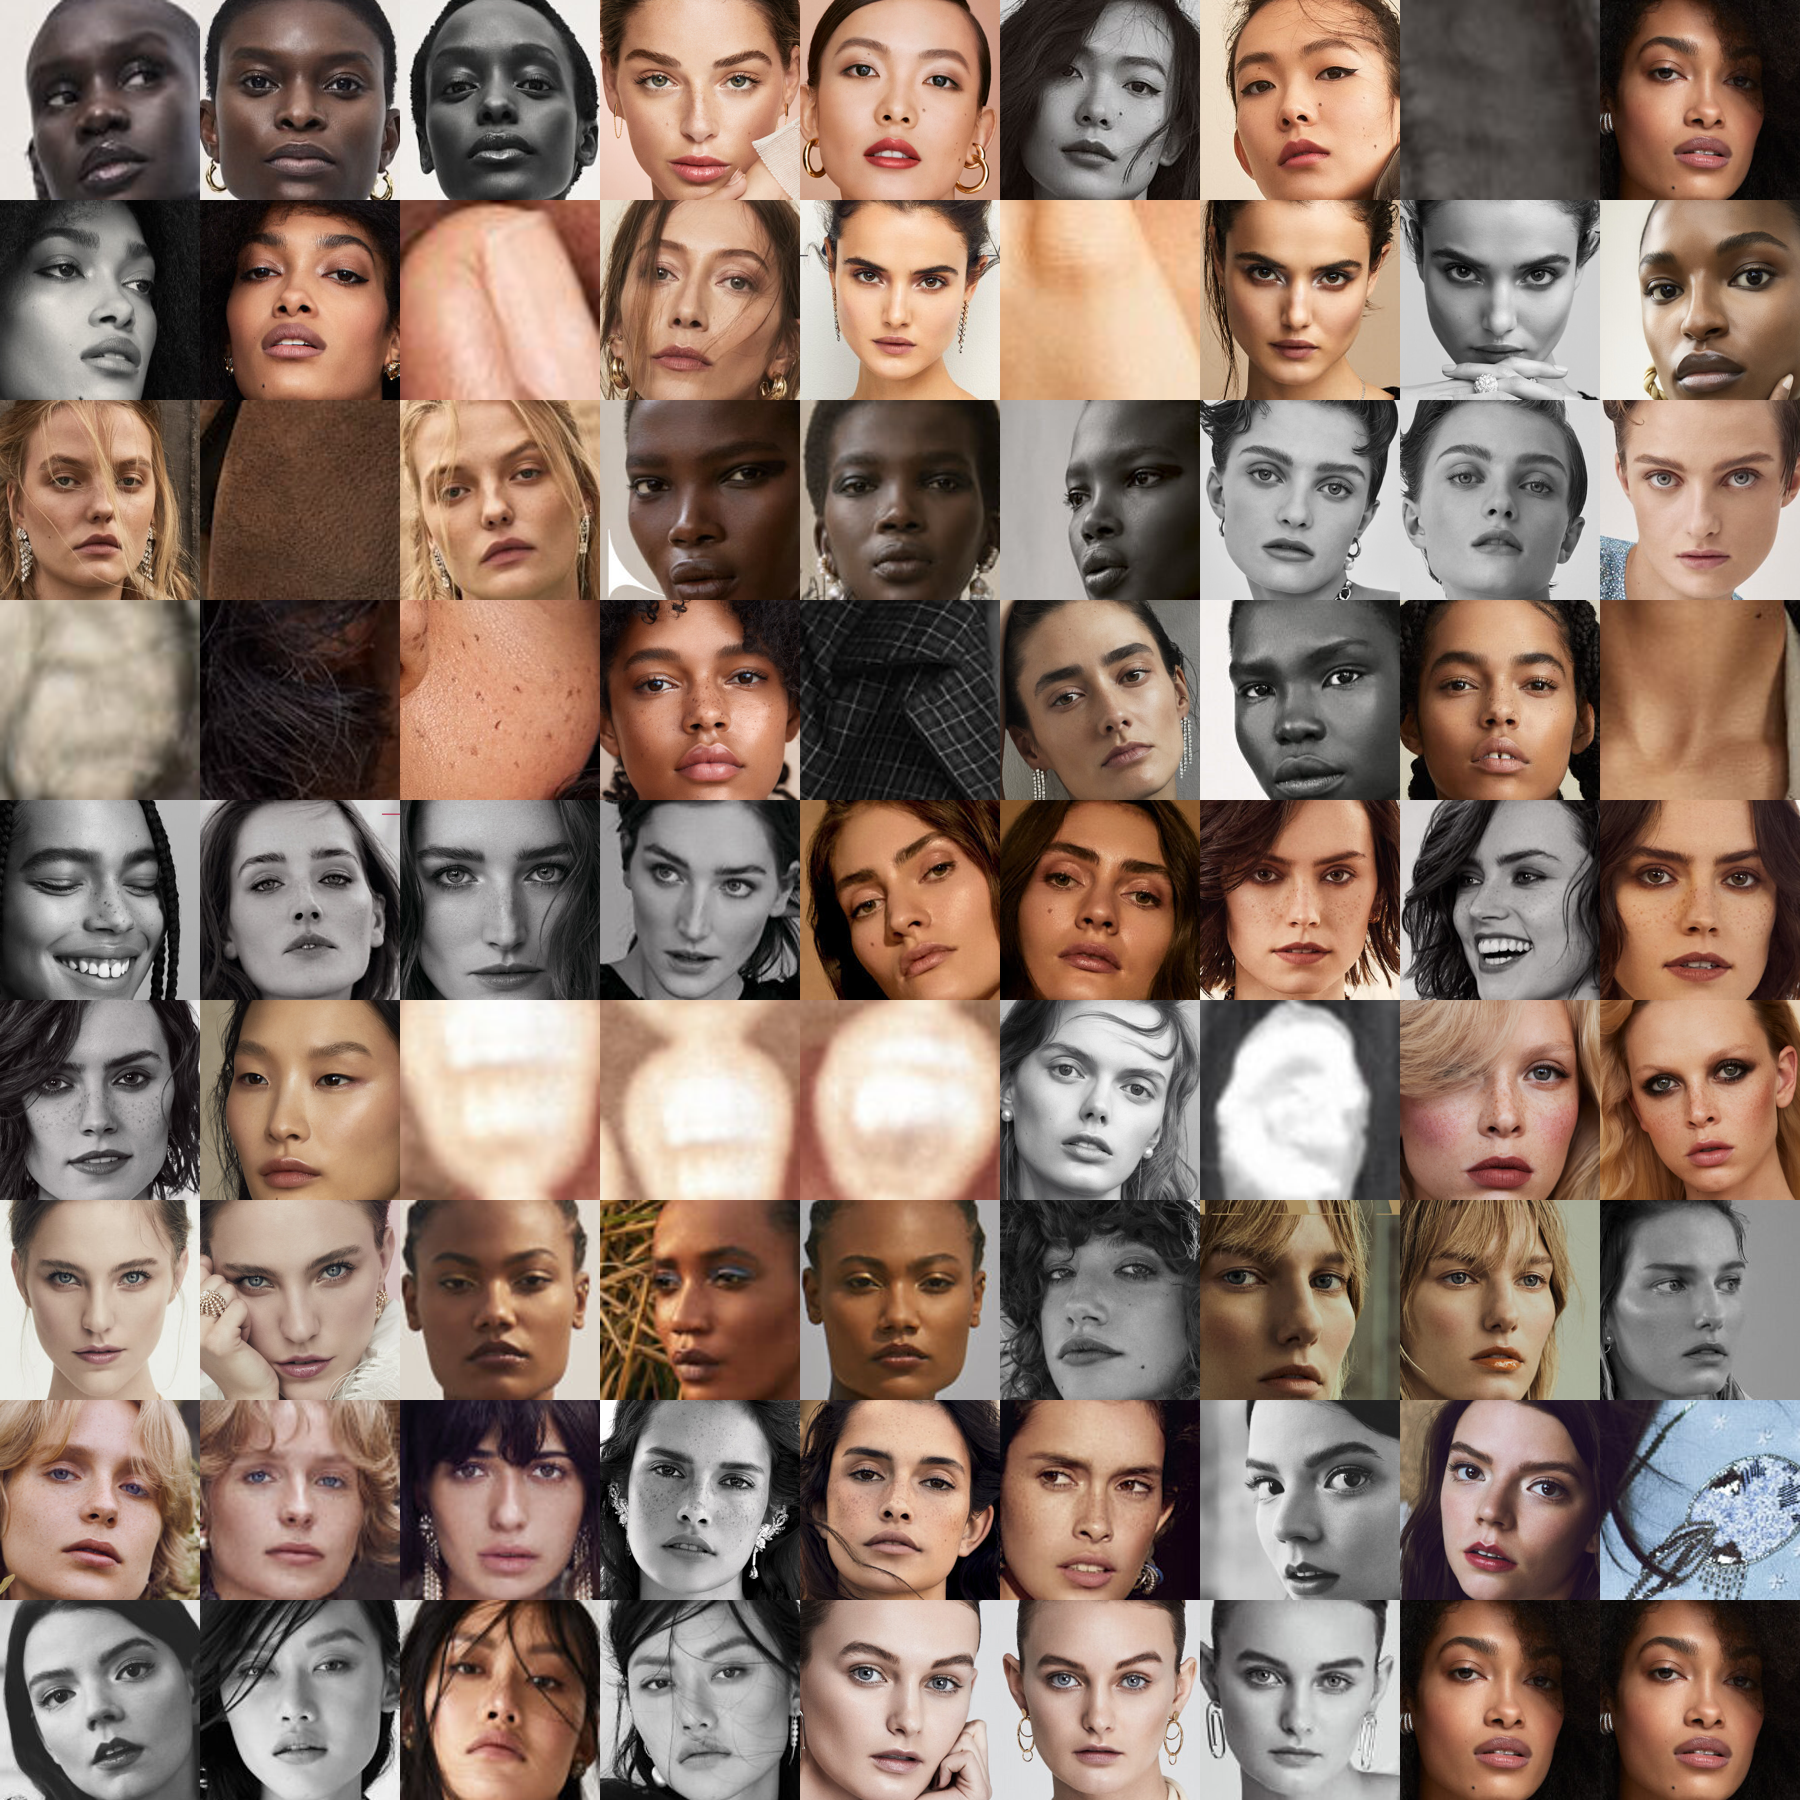

In [38]:
import math
faces_per_row = math.ceil(math.sqrt(len(faces_list)))
while len(faces_list)%faces_per_row != 0:
  faces_list.append(faces_list[faces_per_row - 1])
size = (200, 200)
counter = 1
matrix = None
nueva_fila = True
for img in faces_list:
  img = np.asarray(Image.fromarray(img).resize(size))
  if nueva_fila:
    fila = img
    nueva_fila = False
  else:
    fila = np.hstack([fila, img])
  if counter == faces_per_row:
        matrix = fila
        nueva_fila = True
  elif counter % faces_per_row == 0:
      matrix = np.vstack([matrix, fila])
      nueva_fila = True
  counter += 1
Image.fromarray(matrix)